<a href="https://colab.research.google.com/github/gmrwh92/covid/blob/main/Covid19_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing COVID-19 Data

# Introduction

In this portfolio, we are going to explore the global number of COVID-19.

Main Goal
* Comparing some countries based on their total confirmed COVID-19 cases
 - This is to see the total number number of confirmed cases in each countries.
* Comparing some countries after normalisaion
 - Larger countries have significantly larger populations compared to smaller countries; this factor is being considered in the calculation of confirmed cases per every 10 people.
* Build a model for prediction
  - ARIMA (statistical method for prediction based on historical time series) and LSTM (neural network for time series data prediction).



In [1]:
!pip install pmdarima

In [2]:
## importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm
from pylab import rcParams
import matplotlib.dates as mdates
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime
from pmdarima.arima import auto_arima

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

<ipython-input-2-33ac0d8c159c>:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Dataset for Covid

Johns Hopkins University provides an open dataset that includes data on confirmed cases, deaths, and recovered cases. However, our focus is solely on the confirmed cases. The data is structured with one row per region, featuring columns for Latitude and Longitude, followed by separate columns for each day's data. This dataset has been collected since January 22, 2020, and is continuously updated.


In [3]:
# load the live dataset,
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)
covid

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [4]:
## group our dataset by country and drop some variables that are not related to our analysis
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])
grouped

<ipython-input-4-f0644df322f9>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = covid.groupby('Country/Region').sum()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
Albania,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
Algeria,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
Andorra,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
Angola,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
Winter Olympics 2022,0,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
Yemen,0,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945


## Comparing countries

* Comparing some random countries

<Axes: >

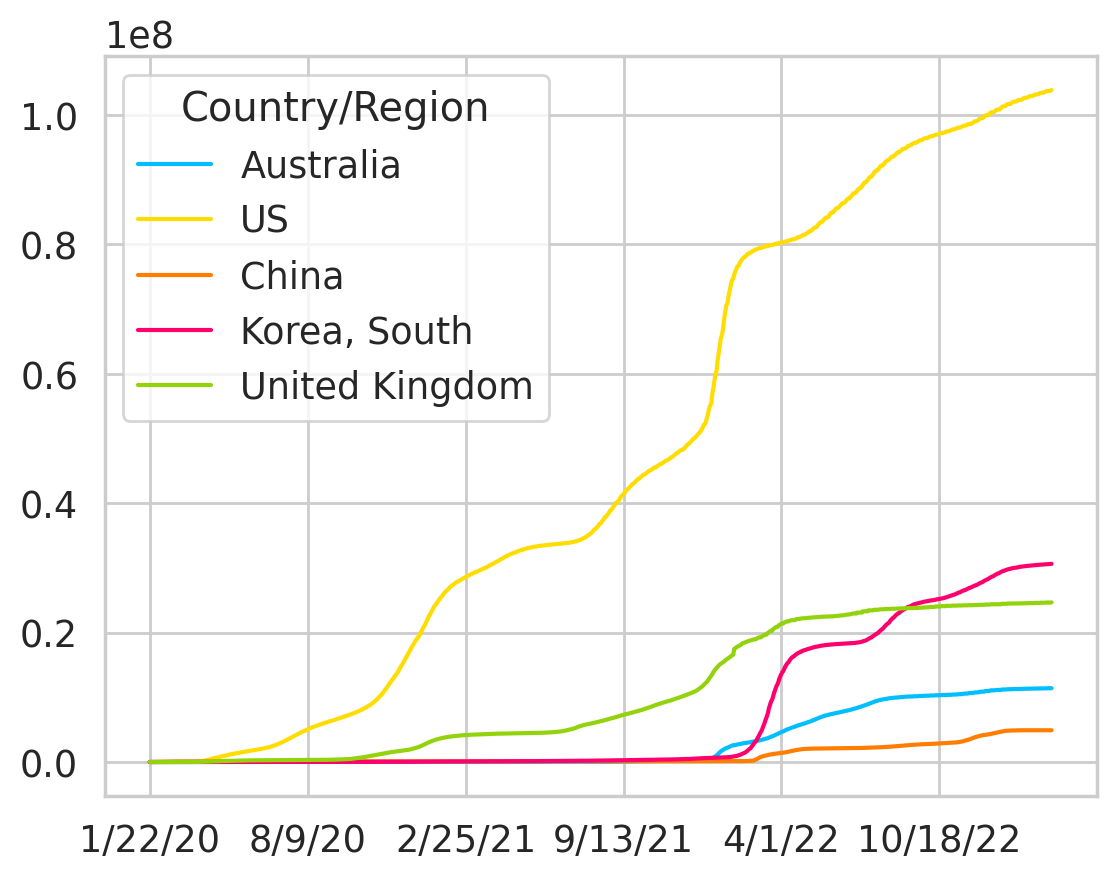

In [5]:
## Produce a plot for "Australia", "US", "China", "Korea" and "United Kingdom"
aa = grouped.loc[["Australia","US","China","Korea, South", "United Kingdom"]]
aa.T.plot()

* Top 10 countries

In [6]:
## Find top 10 countries
top = grouped.iloc[:,-1]
topp = top.nlargest(10)
display(topp)

Country/Region
US                103802702
India              44690738
France             39866718
Germany            38249060
Brazil             37076053
Japan              33320438
Korea, South       30615522
Italy              25603510
United Kingdom     24658705
Russia             22075858
Name: 3/9/23, dtype: int64

<Axes: >

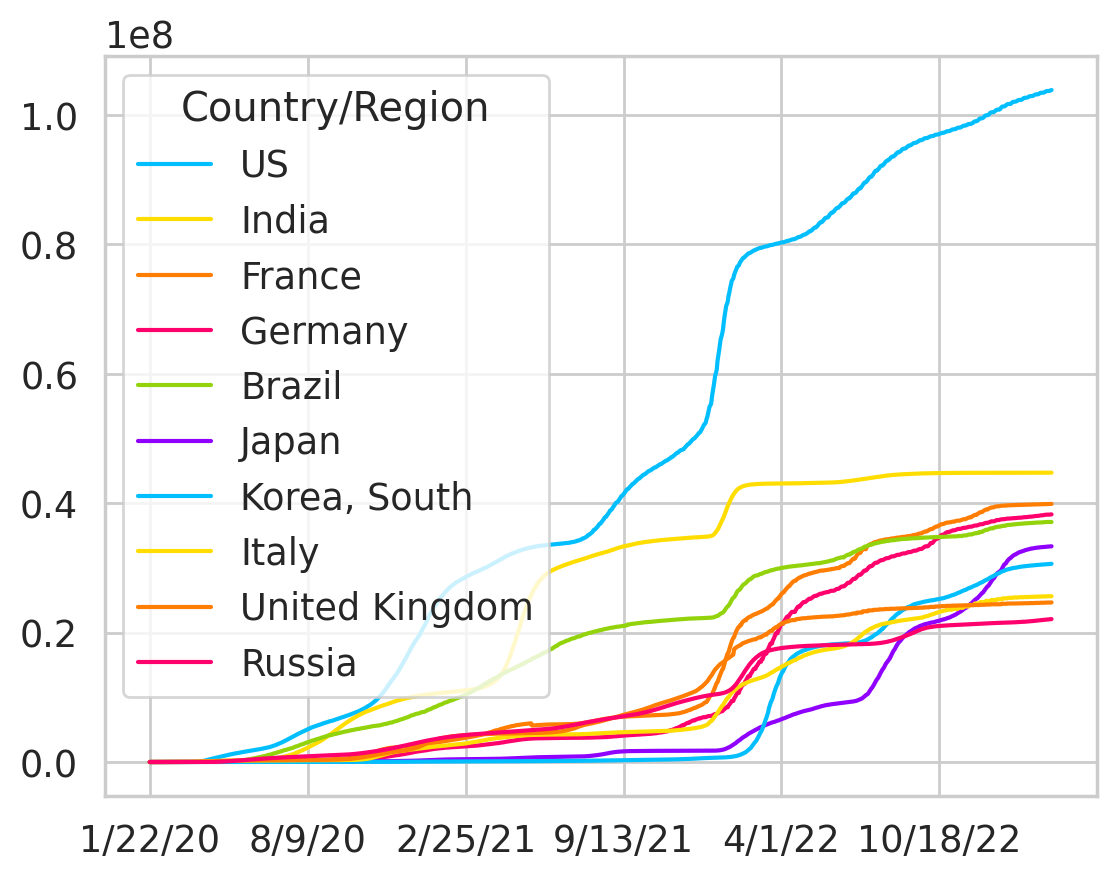

In [7]:
## Plot for top 10 countries
toppp = grouped.loc[["US","India","France", "Germany", "Brazil", "Japan", "Korea, South", "Italy","United Kingdom", "Russia"]]
toppp.T.plot()

* Least 10 Countries

In [8]:
## Find least 10 countries and make a plot
small = grouped.iloc[:,-1]
smalll = small.nsmallest(10)
display(smalll)

Country/Region
Korea, North               1
MS Zaandam                 9
Antarctica                11
Holy See                  29
Winter Olympics 2022     535
Diamond Princess         712
Summer Olympics 2020     865
Tuvalu                  2805
Kiribati                5014
Nauru                   5247
Name: 3/9/23, dtype: int64

<Axes: >

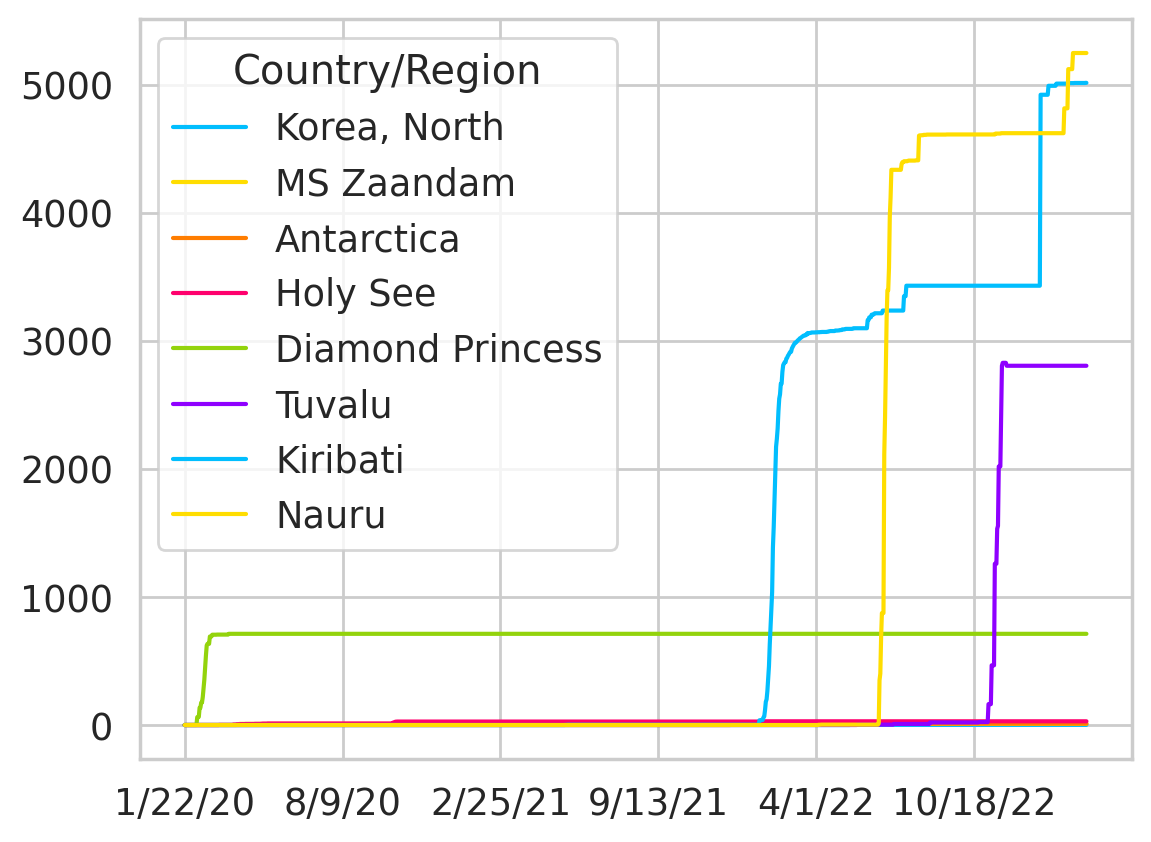

In [9]:
## Plot for least 10 countries
smallll = grouped.loc[["Korea, North","MS Zaandam","Antarctica", "Holy See", "Diamond Princess", "Tuvalu", "Kiribati", "Nauru"]]
smallll.T.plot()

## Dataset for population

We obtained an open dataset from datahub.io containing population figures for various countries. This dataset covers the overall population of each country and spans from 1960 to 2016. In our COVID dataset, we have data for 186 countries, while the population dataset includes information on 263 countries. To ensure consistency, we manually adjusted the country names in our population dataset to match those in our COVID dataset. For instance, 'US' was changed to 'United States' to facilitate data compatibility between the two sets.

In [10]:
## Read population dataset
population = pd.read_csv("population.csv", encoding = "ISO-8859-1")
population.head()

,Country,Country_Code,Year_1960,Year_1961,Year_1962,Year_1963,Year_1964,Year_1965,Year_1966,Year_1967,...,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0


In [11]:
## Get Country name and population in 2016 only
pop = population[['Country','Year_2016']]

## Change column name to merge with our covid dataset
popp = pop.rename(columns={"Country" : "Country/Region"})
poppp = popp.groupby('Country/Region').sum()

## Merge population and covid dataset
npp = pd.merge(poppp,grouped, how = 'inner', left_index=True, right_index=True)
npp.head()

,Year_2016,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,34656032.0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
Albania,2876101.0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
Algeria,40606052.0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
Andorra,77281.0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
Angola,28813463.0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [12]:
## Calculate confirmed cases per 10
npp = npp.iloc[:,-1]/npp['Year_2016'] * 10
npp

Country/Region
Afghanistan           0.060437
Albania               1.162883
Algeria               0.066861
Andorra               6.196866
Angola                0.036541
                        ...   
Vietnam               1.243458
West Bank and Gaza    1.545024
Yemen                 0.004330
Zambia                0.206815
Zimbabwe              0.163635
Length: 190, dtype: float64

* Top 10 countries

<BarContainer object of 10 artists>

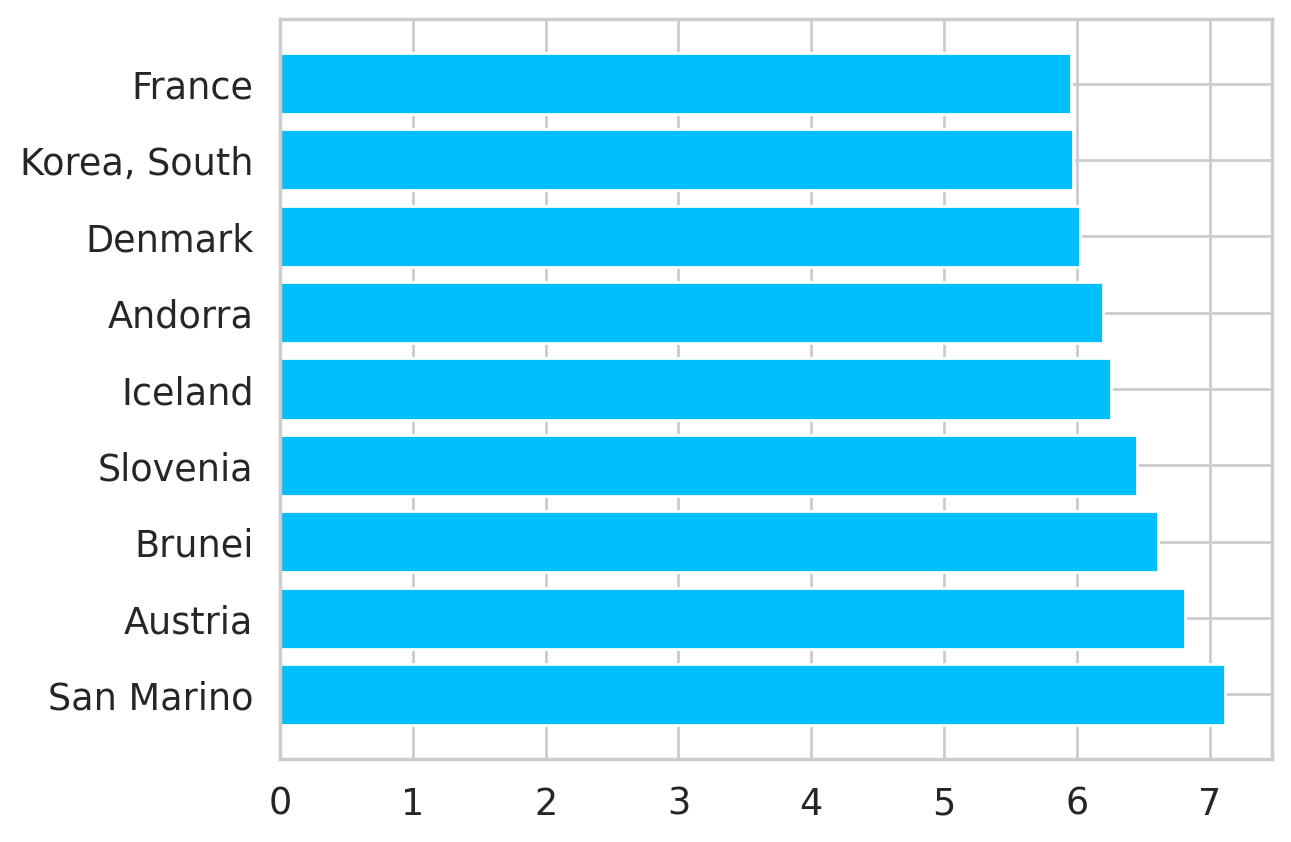

In [13]:
## Find top 10 countries and plot
nptop = npp.nlargest(10)
plt.barh(nptop.index,nptop)

* Least 10 countries

<BarContainer object of 10 artists>

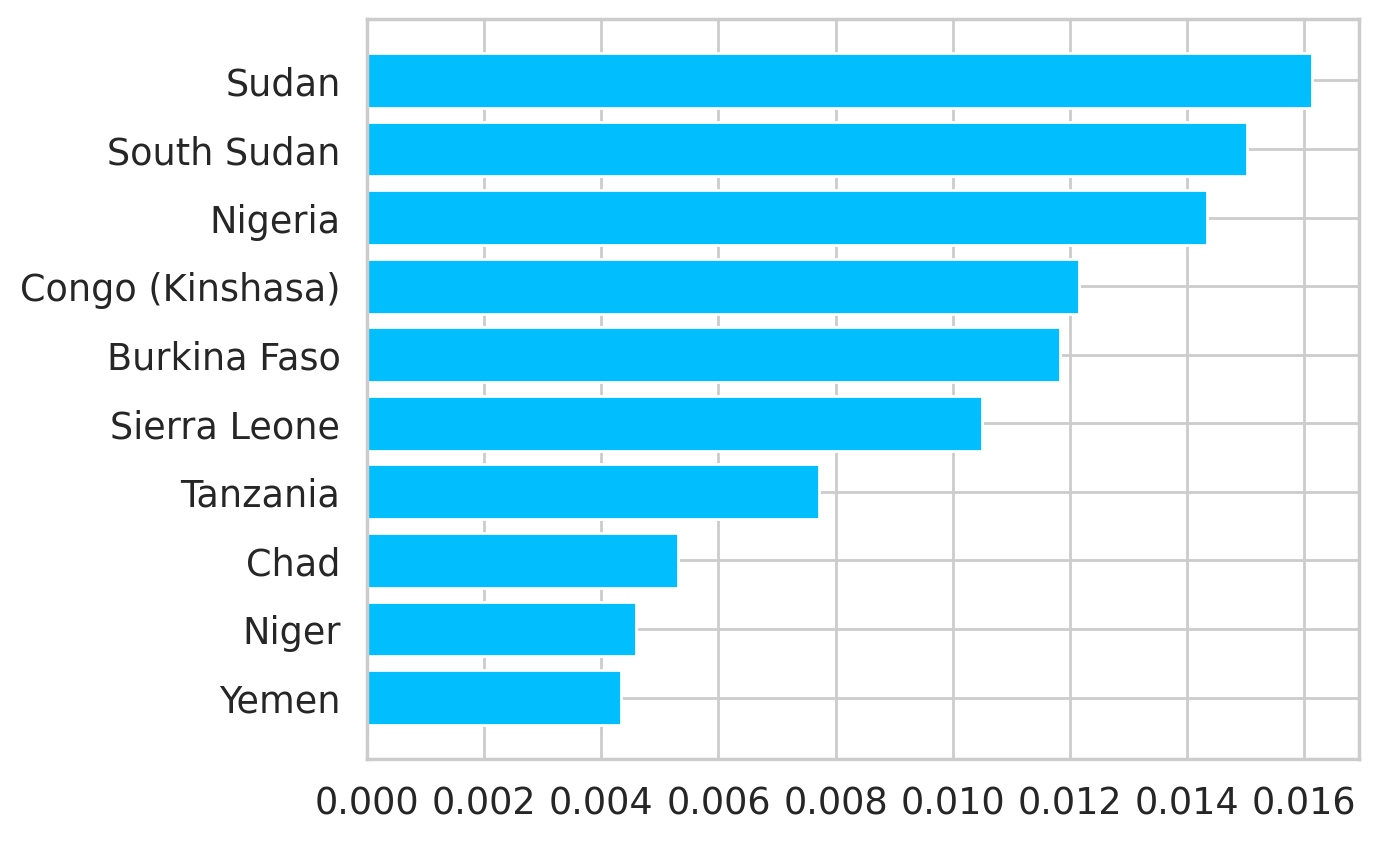

In [14]:
## Find least 10 countries and plot
npsmall = npp.nsmallest(10)
plt.barh(npsmall.index,npsmall)

* We observe that 7 out of every 10 people in San Marino have tested positive for COVID-19. While the US has the highest number of confirmed cases overall, San Marino leads in cases per capita. It's important to note that we cannot definitively conclude whether the US or San Marino has been more severely affected by COVID-19. Nevertheless, this analysis provides a quick insight into the statistics.

# Predictions


### Data pre-processing
The live dataset provides cumulative numbers, but our plan is to calculate new daily cases for predictions in Korea. Afterward, we will split these new daily cases into a training set and a test set for validation. The dataset spans 1,146 days, with 90% of the data allocated to the training set. This means we will train the model using data from January 22, 2020, to December 31, 2022. Then, we will validate the model by comparing actual and predicted data from January 1, 2023, to March 9, 2023.

In [15]:
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])
grouped

<ipython-input-15-a620f5bf186a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = covid.groupby('Country/Region').sum()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
Albania,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
Algeria,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
Andorra,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
Angola,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
Winter Olympics 2022,0,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
Yemen,0,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945


In [16]:
## Extract the data for Korea
grouped = grouped.loc[["Korea, South"]]
total_cases = grouped.sum(axis=0)
total_cases.index = pd.to_datetime(total_cases.index)
total_cases

2020-01-22           1
2020-01-23           1
2020-01-24           2
2020-01-25           2
2020-01-26           3
                ...   
2023-03-05    30569215
2023-03-06    30581499
2023-03-07    30594297
2023-03-08    30605187
2023-03-09    30615522
Length: 1143, dtype: int64

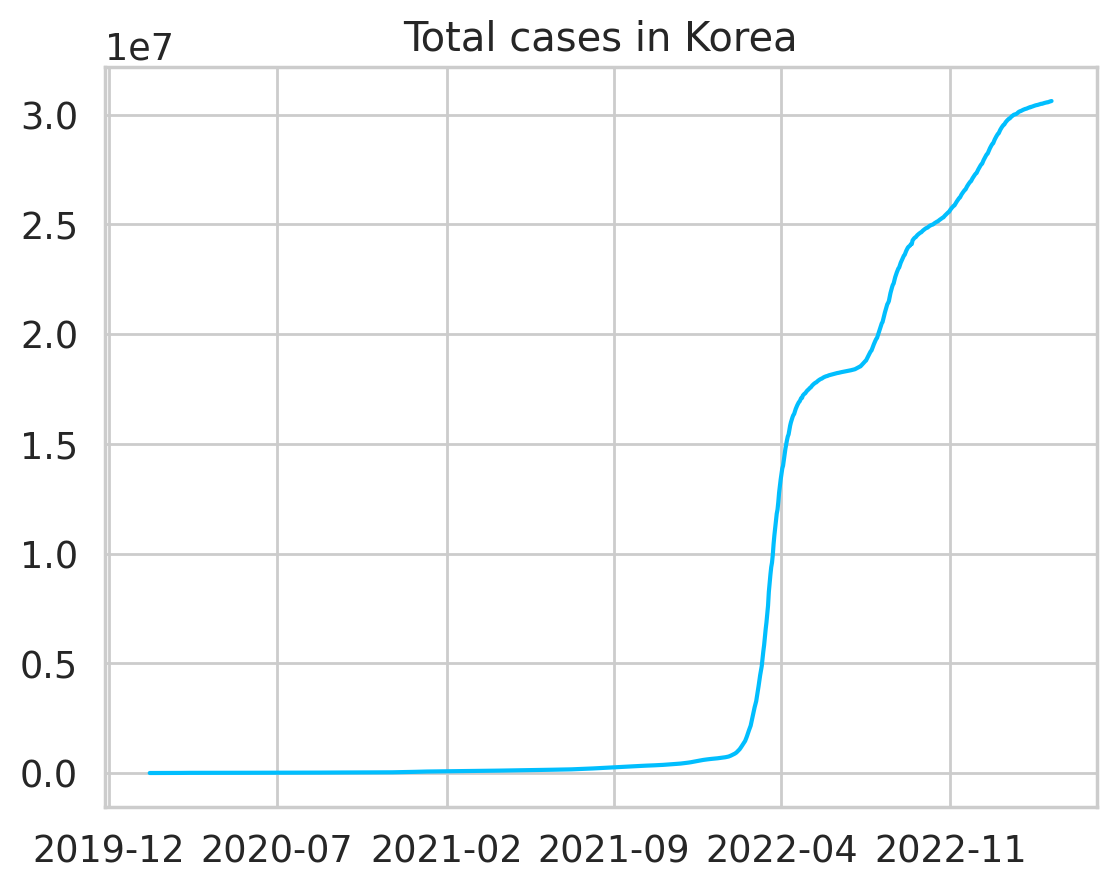

In [17]:
## total number of cases in Korea since 2020
ax = plt.gca()
plt.plot(total_cases)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.title("Total cases in Korea");

* We will subtract the number of cases on the current date from those on the previous date to calculate the daily new cases

In [18]:
daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)
daily_cases

2020-01-22        1
2020-01-23        0
2020-01-24        1
2020-01-25        0
2020-01-26        1
              ...  
2023-03-05    14113
2023-03-06    12284
2023-03-07    12798
2023-03-08    10890
2023-03-09    10335
Length: 1143, dtype: int64

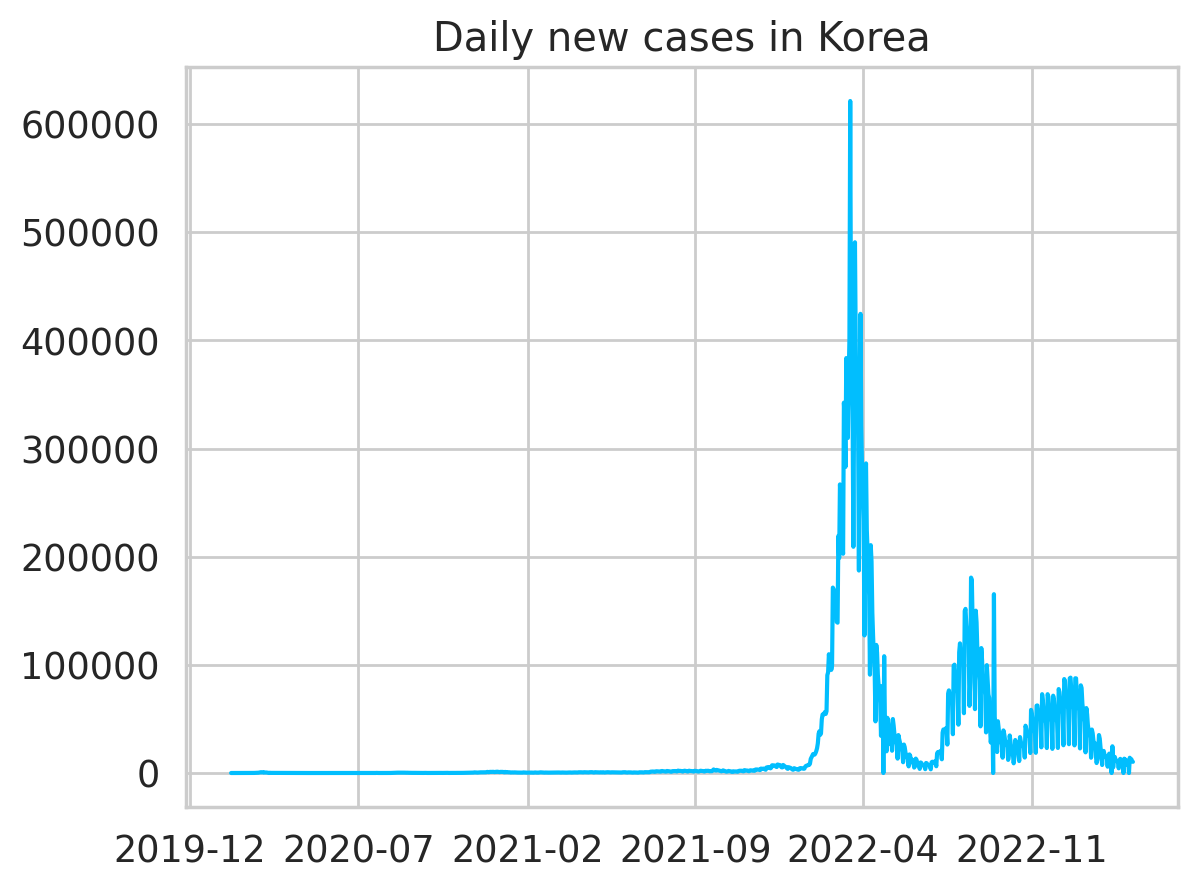

In [19]:
## plot daily cases
ax = plt.gca()
plt.plot(daily_cases)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.title("Daily new cases in Korea");

* This plot could provide insight into the peak of COVID-19 spread in Korea.

In [20]:
## split data into train and test set
daily_cases.index = pd.to_datetime(daily_cases.index)
train_data = daily_cases[:'2022']
test_data = daily_cases['2023':]
test_data1 = test_data

In [21]:
test_data

2023-01-01    22735
2023-01-02    81056
2023-01-03    78575
2023-01-04    64106
2023-01-05    56954
              ...  
2023-03-05    14113
2023-03-06    12284
2023-03-07    12798
2023-03-08    10890
2023-03-09    10335
Length: 68, dtype: int64

## ARIMA Model

* Test for Stationarity before building ARIMA

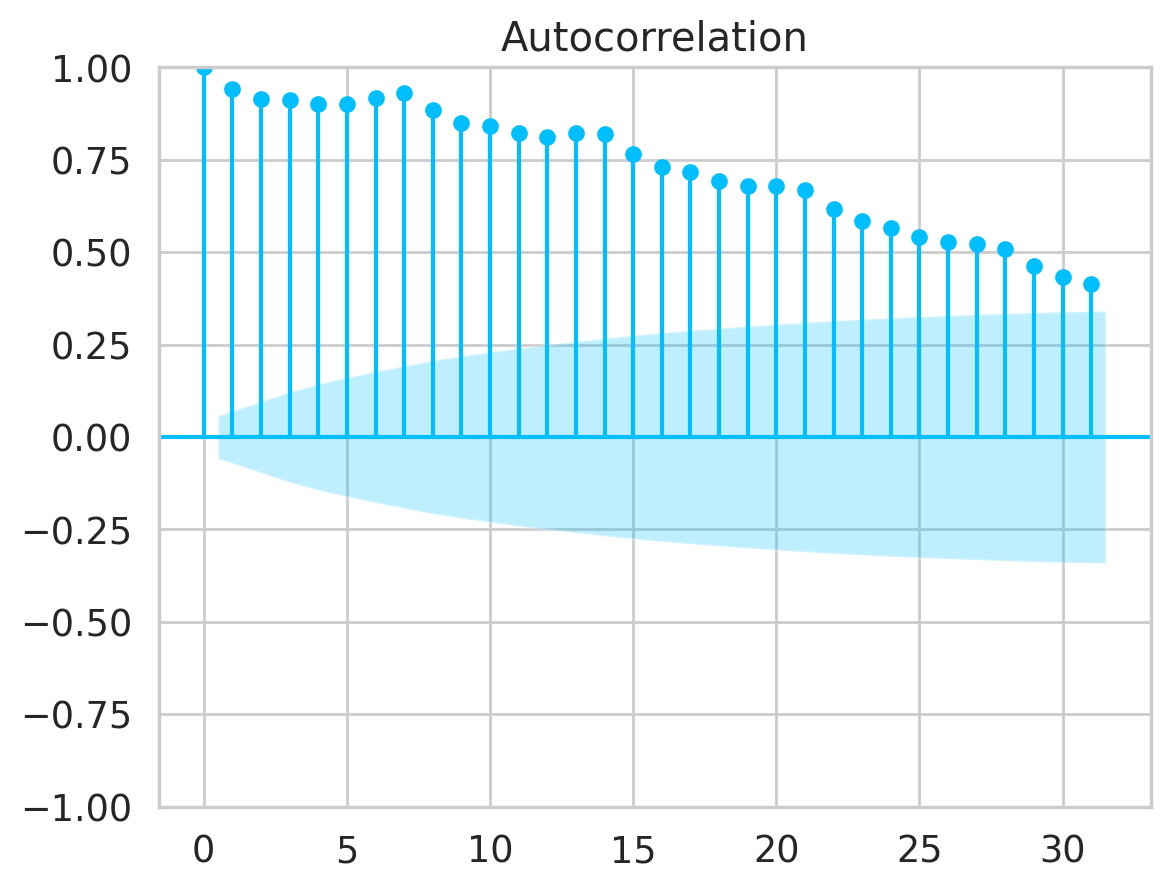

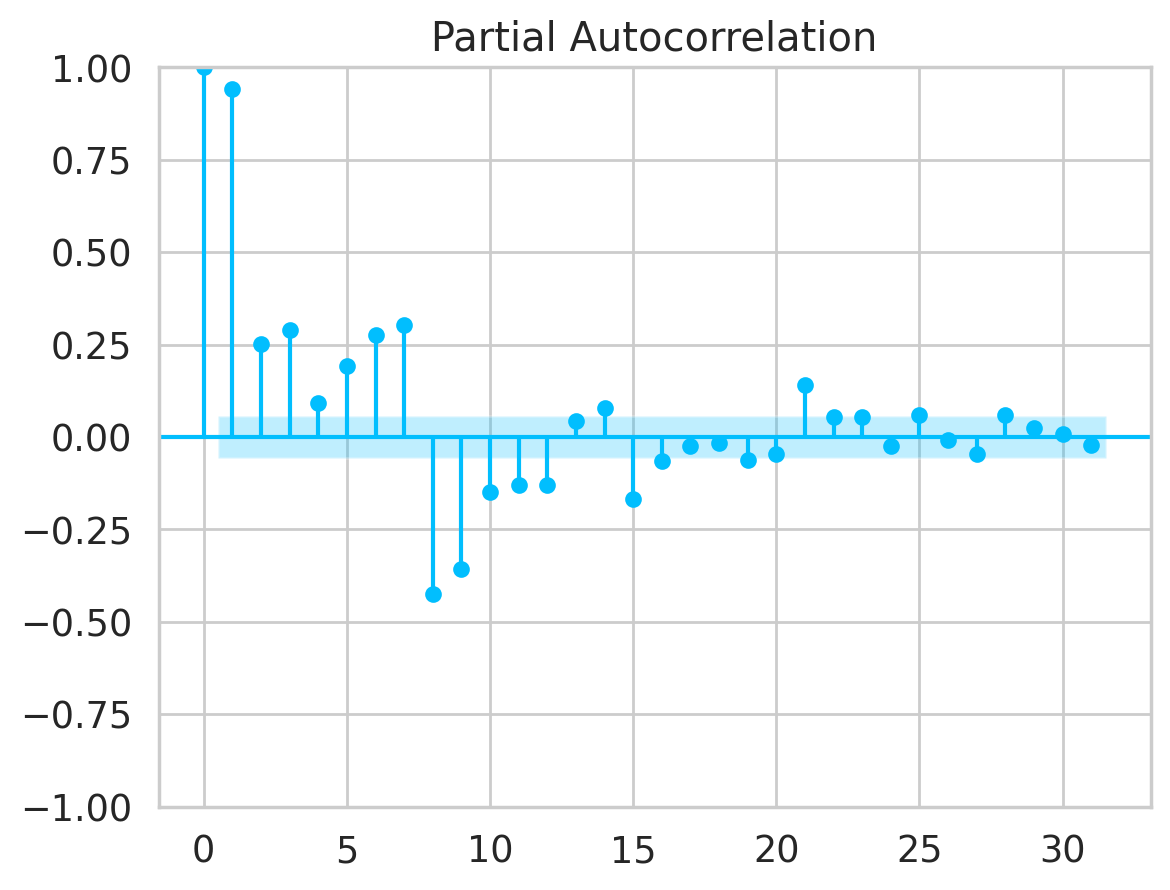

In [22]:
## Autocorrelation Function (ACF) and Partial Autorreclation Function (PACF)
plot_acf(daily_cases)
plot_pacf(daily_cases)
plt.show()

In [23]:
## Augmented Dicky-Fullter Test
result = adfuller(daily_cases)

print('ADF statistics: %f' % result[0])
print('p-value %f' % result[1])
print('Critical values')
for key, value in result[4].items():
  print('\t%s: %3f' % (key,value))

ADF statistics: -4.031051
p-value 0.001256
Critical values
	1%: -3.436202
	5%: -2.864124
	10%: -2.568146


* All ACF, PACF, and ADF tests indicate that our dataset is stationary. ACF values drop off quickly, PACF values approach 0, and the p-value from the ADF test is less than 0.05. These results collectively confirm the stationarity of the time series in this dataset.

In [24]:
## find the optimal p(AR specification), d(Integer order), q(MA specification)
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=1,
                      seasonal=False,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24337.681, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24555.250, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24475.484, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24363.711, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24553.256, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24314.871, Time=1.50 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24373.270, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24316.443, Time=1.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24303.250, Time=1.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24324.239, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24189.796, Time=1.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=24308.444, Time=0.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=24096.895, Time=6.05 sec
 ARIMA(3,1,3)(0,0,0)[0] i

* Fit model


In [25]:
## we fit a model, p(AR specification) = 5, d(Integer order) = 1, q(MA specification) = 4 based on best model selection
model = ARIMA(train_data, order=(5,1,4))
model_fit = model.fit()

## set up the date period we want to forecast
start_index = datetime(2023, 1, 1)
end_index = datetime(2023, 3, 9)
forecast = model_fit.predict(start = start_index, end=end_index, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [26]:
forecast.head(15)

2023-01-01    47970.620541
2023-01-02    83484.942408
2023-01-03    92006.779122
2023-01-04    69646.327381
2023-01-05    67640.931176
2023-01-06    73474.868385
2023-01-07    55226.776837
2023-01-08    52557.405422
2023-01-09    81537.413989
2023-01-10    88802.306534
2023-01-11    69426.740207
2023-01-12    68406.086134
2023-01-13    72967.912578
2023-01-14    56865.698025
2023-01-15    55178.621526
Freq: D, Name: predicted_mean, dtype: float64

In [27]:
test_data.head(15)

2023-01-01    22735
2023-01-02    81056
2023-01-03    78575
2023-01-04    64106
2023-01-05    56954
2023-01-06    53608
2023-01-07    46766
2023-01-08    19106
2023-01-09    60041
2023-01-10    54343
2023-01-11    43953
2023-01-12    39726
2023-01-13    36552
2023-01-14    32570
2023-01-15    14144
dtype: int64

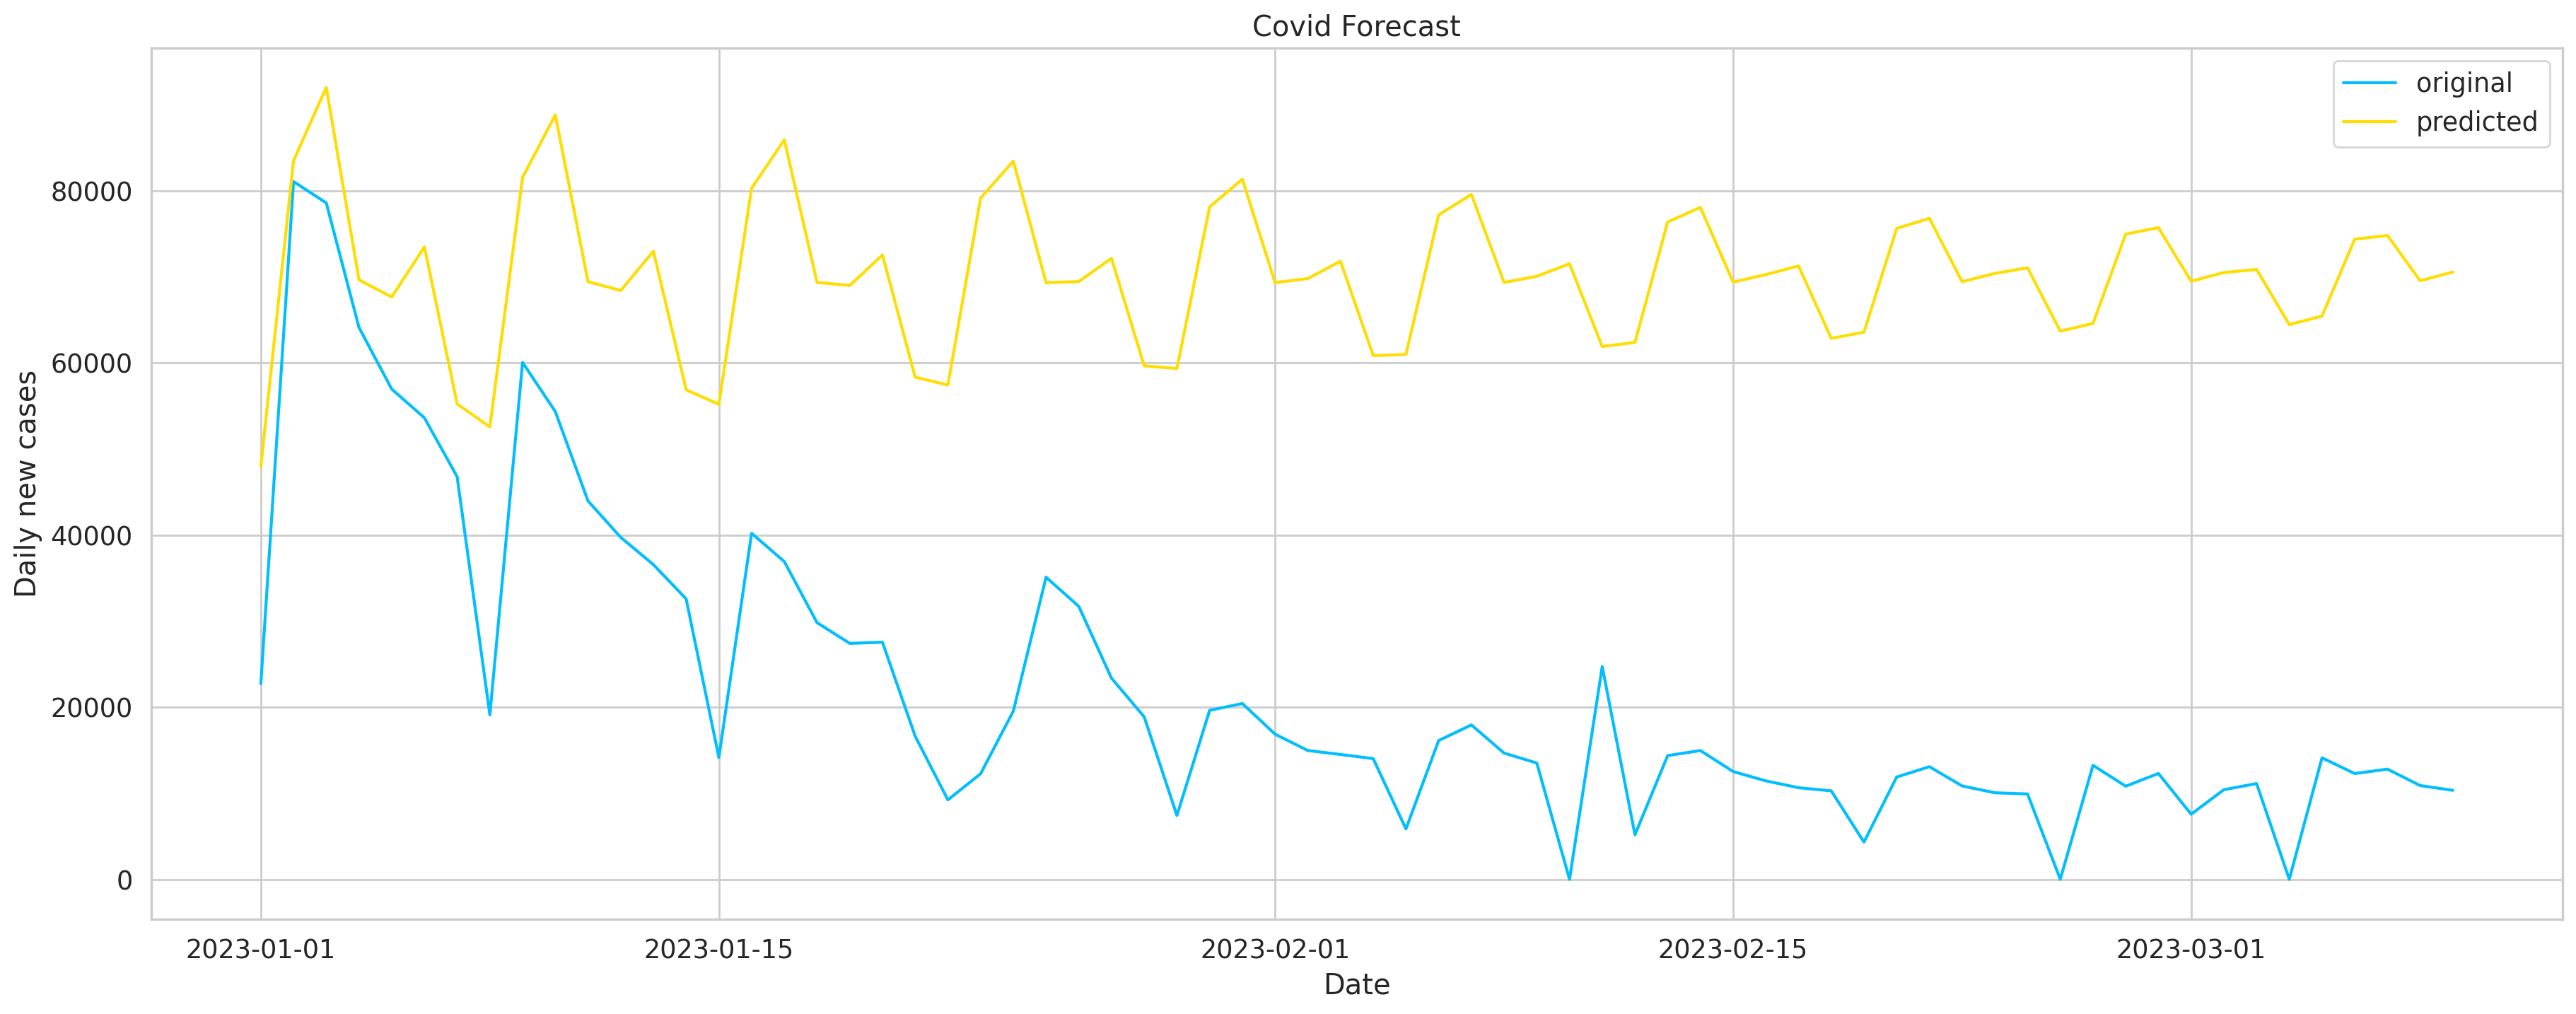

In [28]:
##plot the real cases vs predicted cases based on ARIMA
plt.figure(figsize=(22,8))
plt.plot(test_data, label="original")
plt.plot(forecast,label = "predicted")
plt.title("Covid Forecast")
plt.xlabel("Date")
plt.ylabel("Daily new cases")
plt.legend()
plt.show()

## LSTM (Long Short-Term Memory), Deep Learning

In [29]:
## Scale the dataset to increase the training speed
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [30]:
## Convert dataset into smaller periods
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [31]:
seq_length = 7
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [32]:
## define model
class LSTM(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTM, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred


In [33]:
## define training
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [34]:
##train
model = LSTM(
  n_features=1,
  n_hidden=128,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)


Epoch 0 train loss: 13.101578712463379 test loss: 0.043112628161907196
Epoch 10 train loss: 11.970710754394531 test loss: 0.0309152752161026
Epoch 20 train loss: 11.9959135055542 test loss: 0.030177392065525055
Epoch 30 train loss: 11.982259750366211 test loss: 0.045327819883823395
Epoch 40 train loss: 11.953926086425781 test loss: 0.04582587629556656
Epoch 50 train loss: 11.904031753540039 test loss: 0.04548385739326477


In [35]:
## predict
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [36]:
## convert scaled values into the original
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [37]:
true_cases

array([19106.    , 60041.    , 54342.996 , 43953.    , 39726.004 ,
       36552.    , 32570.    , 14144.    , 40199.    , 36908.    ,
       29816.    , 27408.002 , 27539.    , 16624.    ,  9227.    ,
       12261.999 , 19538.    , 35096.    , 31711.    , 23367.    ,
       18871.    ,  7416.    , 19629.    , 20420.    , 16862.    ,
       14961.    , 14504.    , 14018.    ,  5849.9995, 16120.    ,
       17934.    , 14663.999 , 13503.999 ,     0.    , 24716.    ,
        5174.    , 14370.999 , 14956.999 , 12519.    , 11436.    ,
       10641.    , 10274.    ,  4324.    , 11880.    , 13081.999 ,
       10845.001 , 10051.    ,  9913.    ,     0.    , 13238.    ,
       10817.    , 12291.    ,  7561.0005, 10408.    , 11121.    ,
           0.    , 14113.    , 12284.    , 12798.    , 10890.    ],
      dtype=float32)

In [38]:
predicted_cases

array([33414.19720949, 33018.72701266, 32727.99647021, 32505.33790768,
       32331.1490946 , 32193.66267477, 32084.94656131, 31999.13559282,
       31931.63763028, 31878.74239202, 31837.4594327 , 31805.35612221,
       31780.46737688, 31761.22853645, 31746.3850952 , 31734.95335399,
       31726.15561188, 31719.39007644, 31714.19383043, 31710.20116925,
       31707.13202796, 31704.7780938 , 31702.97271657, 31701.58165027,
       31700.51231145, 31699.69063335, 31699.06338049, 31698.57963198,
       31698.20466902, 31697.91766033, 31697.69777464, 31697.52880985,
       31697.39919302, 31697.3019804 , 31697.22328447, 31697.16310523,
       31697.11449892, 31697.08209471, 31697.05663427, 31697.03580299,
       31697.0172863 , 31697.00571337, 31696.99876961, 31696.98951127,
       31696.98719668, 31696.98025292, 31696.97793834, 31696.97793834,
       31696.97330916, 31696.97330916, 31696.97330916, 31696.9663654 ,
       31696.9663654 , 31696.96867999, 31696.96867999, 31696.9663654 ,
      

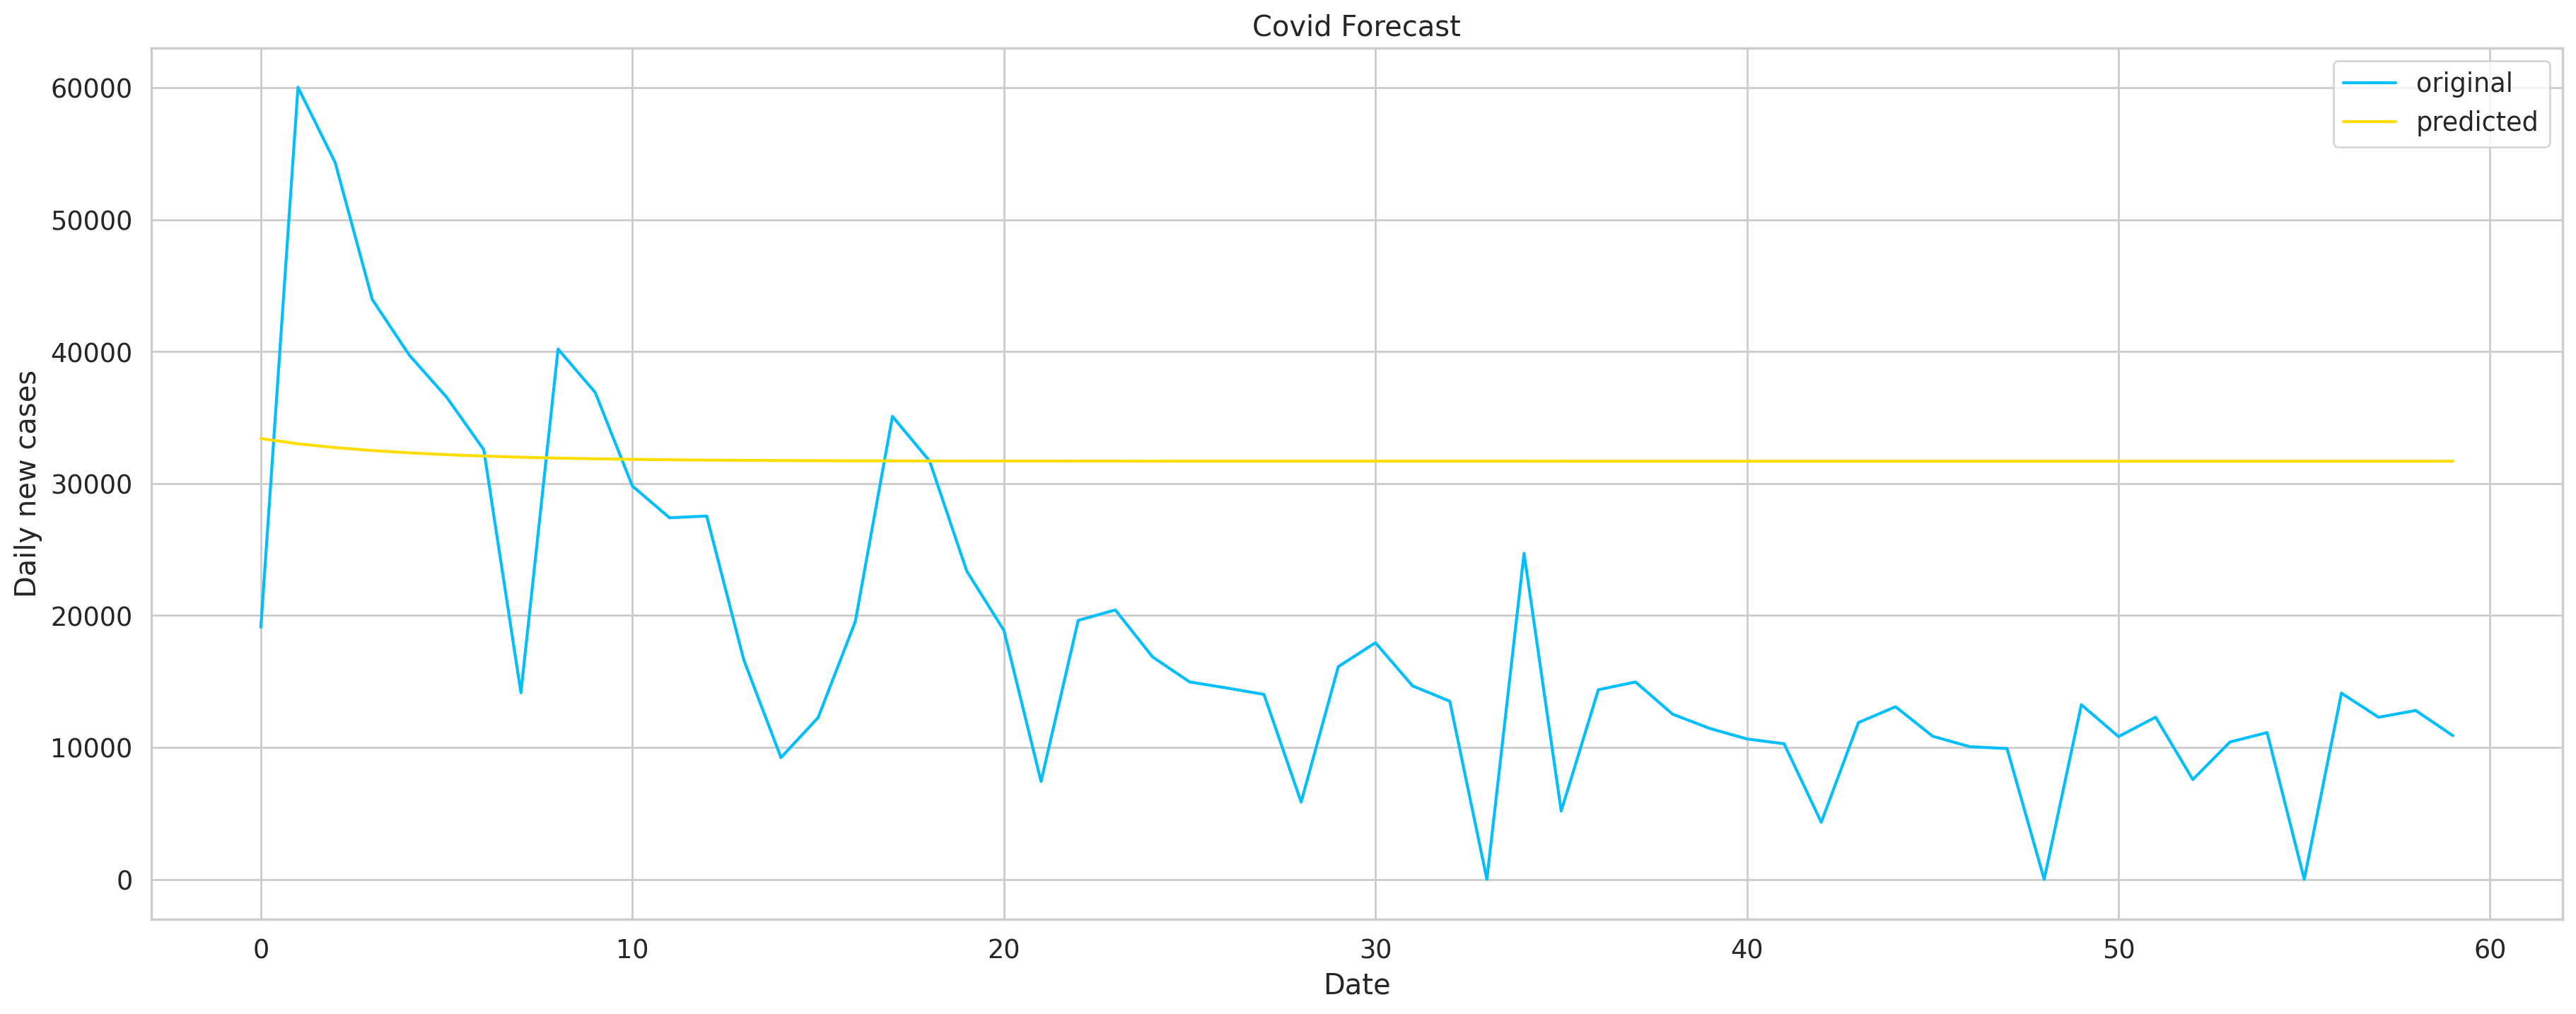

In [39]:
## plot real cases vs predicted cases based on LSTM
plt.figure(figsize=(22,8))
plt.plot(true_cases, label="original")
plt.plot(predicted_cases,label = "predicted")
plt.title("Covid Forecast")
plt.xlabel("Date")
plt.ylabel("Daily new cases")
plt.legend()
plt.show()

## Evaluation Arima vs LSTM vs Raw data

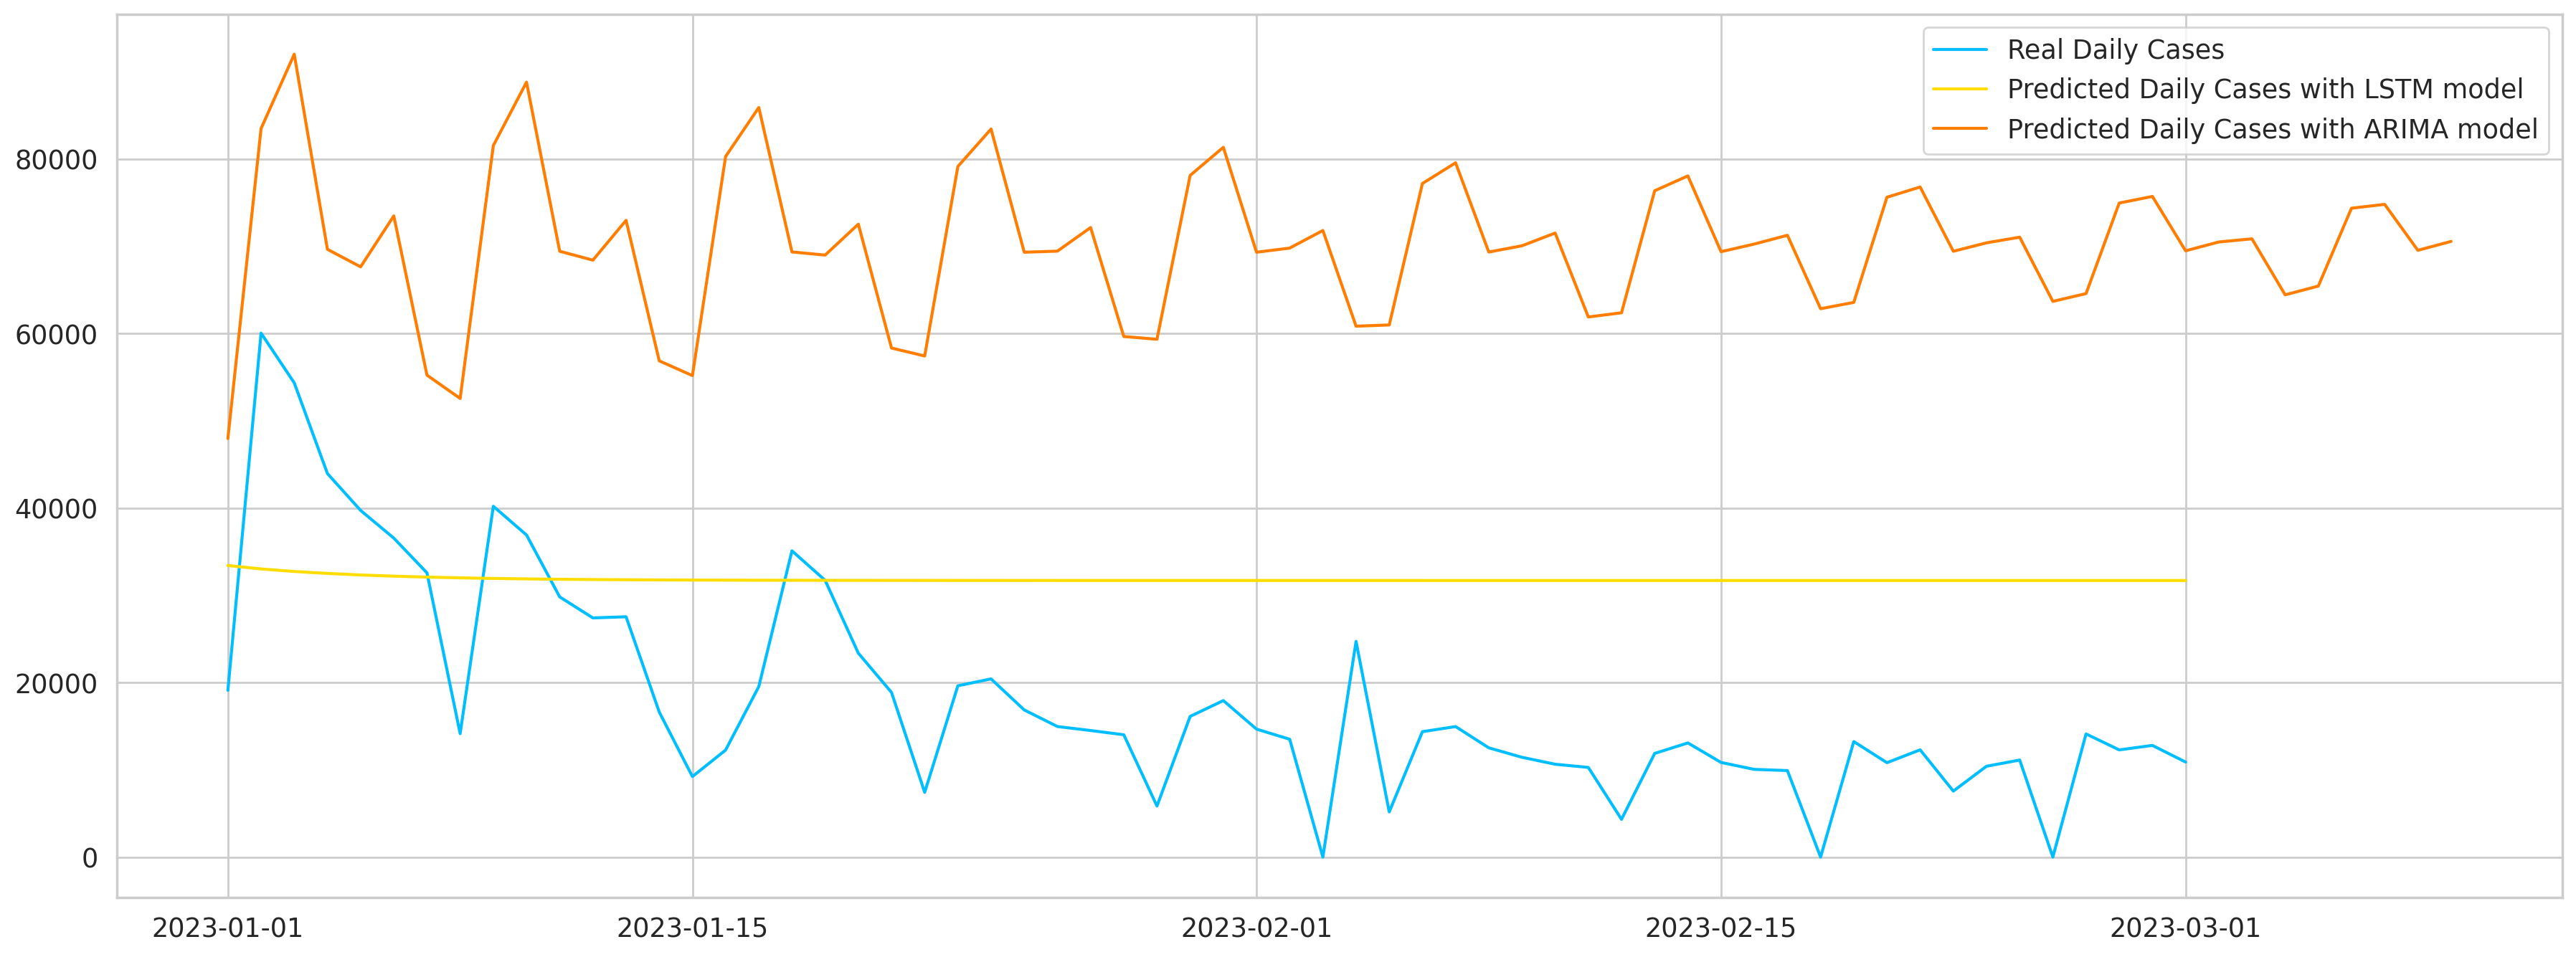

In [40]:
plt.figure(figsize=(22,8))
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases with LSTM model'
)

plt.plot(forecast,label = "Predicted Daily Cases with ARIMA model")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.legend()

In [41]:
## evaluation criteria
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [42]:
## MAE for LSTM model
MAE(true_cases, predicted_cases)

16715.829135087195

In [43]:
## MAE for ARIMA model
MAE(np.array(test_data1), np.array(forecast))

48082.868128476926

* Both the Arima (statistical) and LSTM (deep learning) models do not perform well, with LSTM outperforming ARIMA